In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


training_data_url = "https://raw.githubusercontent.com/ummisco-deep-learning/Soil_Moisture_Challenge/master/data/Train.csv"
train = pd.read_csv(training_data_url)
columns = train.keys()

print(columns)

Index(['timestamp', 'Soil humidity 1', 'Irrigation field 1', 'Soil humidity 2',
       'Irrigation field 2', 'Soil humidity 3', 'Irrigation field 3',
       'Soil humidity 4', 'Irrigation field 4', 'Air temperature (C)',
       'Air humidity (%)', 'Pressure (KPa)', 'Wind speed (Km/h)',
       'Wind gust (Km/h)', 'Wind direction (Deg)'],
      dtype='object')


In [ ]:
slot1 = np.array(train["Soil humidity 1"])
slot2 = np.array(train["Soil humidity 2"])
slot3 = np.array(train["Soil humidity 3"])
slot4 = np.array(train["Soil humidity 4"])

irrigation1 = np.array(train["Irrigation field 1"])
irrigation2 = np.array(train["Irrigation field 2"])
irrigation3 = np.array(train["Irrigation field 3"])
irrigation4 = np.array(train["Irrigation field 4"])

In [ ]:
mask1_not_na = np.isnan(slot1)
slot1 = slot1[~mask1_not_na]

mask2_not_na = np.isnan(slot2)
slot2 = slot2[~mask2_not_na]


mask3_not_na = np.isnan(slot3)
slot3 = slot3[~mask3_not_na]

mask4_not_na = np.isnan(slot4)
slot4 = slot4[~mask4_not_na]

In [ ]:
def windowed_dataset(data, window_size, batch_size):
  # Transform the pandas Dataframe to a tensorflow data
  dataset = tf.data.Dataset.from_tensor_slices(data)  

  # Partition the dataset with element of sizw window, drop the last one if its size is < window
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)  
  # Each set of window+1 element is fit into a list
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  # We separate the window first from the last element [w1, ..., wn-1][wn]
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))  

  # Finally come batching which make learning faster
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
data = slot2

# We find when to split our data into training/validation .
train_time = int(len(data) * .7)

# We need this one to get the index of each dataset, it will make sense at the next plot
time = np.arange(len(data))

In [ ]:
time_train = time[:train_time]
x_train = data[:train_time]
time_valid = time[train_time:]
x_valid = data[train_time:]

Text(0.5, 1.0, 'Training set')

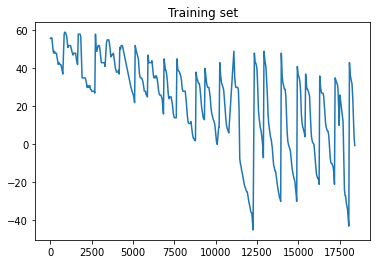

In [ ]:
plt.plot(time_train, x_train)
plt.title("Training set")

Text(0.5, 1.0, 'Validation set')

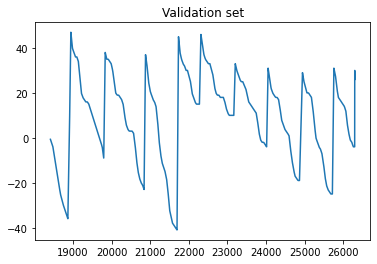

In [ ]:
plt.plot(time_valid, x_valid)
plt.title("Validation set")

In [ ]:
import tensorflow as tf

window_size=30
batch_size=16
training_set = windowed_dataset(x_train, window_size, batch_size)

In [ ]:
inputs = Input(shape=(window_size,))
predictions = Dense(1)(inputs)
model = Model(inputs, predictions)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [ ]:
model.fit(training_set, epochs=10, verbose=1)

Epoch 1/10
1149/1149 [==============================] - 3s 3ms/step - loss: 38.8448
Epoch 2/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.3084
Epoch 3/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2577
Epoch 4/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2252
Epoch 5/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1992
Epoch 6/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1784
Epoch 7/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1615
Epoch 8/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1479
Epoch 9/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1367
Epoch 10/10
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1275


In [ ]:
forecast = []
for time in range(len(slot2) - window_size):
  forecast.append(model.predict(slot2[time : time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

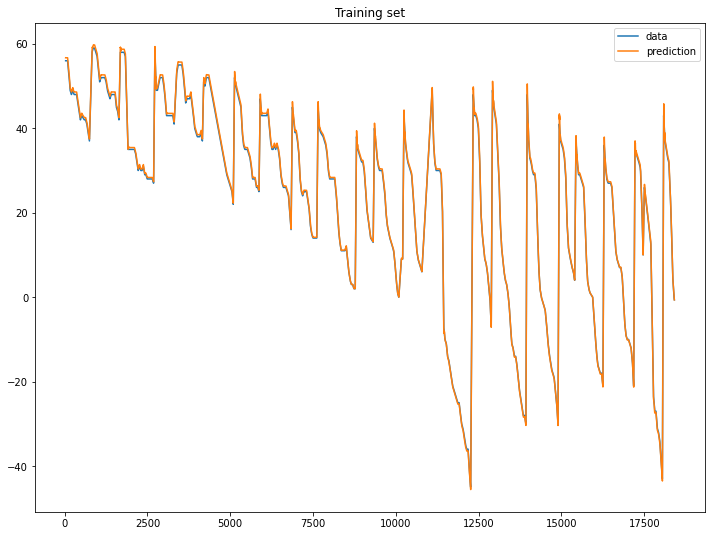

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(time_train[window_size:], data[window_size:train_time], label="data")
plt.plot(time_train[window_size:], results[:train_time-window_size], label="prediction")
plt.title("Training set")
plt.legend()

In [ ]:
np.sqrt(np.mean(np.power((data[window_size:train_time]-results[:train_time-window_size]),2)))

0.5363852646760926

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We predict for the entire dataset
forecast = []
for time in range(len(slot2) - window_size):
  forecast.append(model.predict(slot2[time : time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

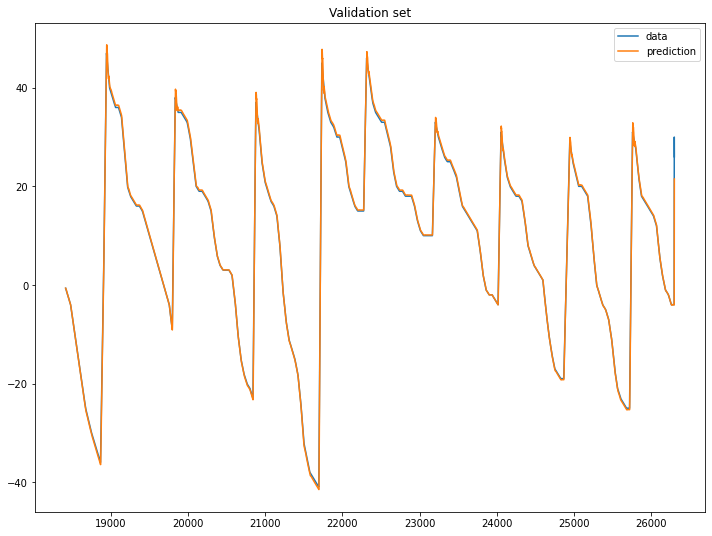

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(time_valid, data[train_time:], label="data")
plt.plot(time_valid, results[train_time-window_size:], label="prediction")
plt.title("Validation set")
plt.legend()